# Import all packages and define functions used for data-preprocessing 
# Reads the dataset

In [8]:
#### Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, neighbors, svm
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve

import warnings
# To ignore any future warnings
warnings.filterwarnings("ignore")

# Repeated functions
def getMode(df, attribute, condAtt, cond):
    return (df[attribute][df[condAtt]==cond].mode()[0])

def replaceWithMode(df, attribute, condAtt, cond):
    mode = getMode(df, attribute, condAtt, cond)
    df[attribute] = df[attribute].mask(((df[condAtt]==cond) & (df[attribute]=='?')), mode)
    

# read the dataset and set skipinitialspace to true to be able to .replace
df = pd.read_csv('./HouseholderAtRisk(1).csv', skipinitialspace=True)

df.info()

rs = 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 18 columns):
ID                        39999 non-null int64
Age                       39032 non-null float64
WorkClass                 39027 non-null object
Weighting                 38707 non-null float64
Education                 39027 non-null object
NumYearsEducation         39027 non-null float64
Marital-Status            39027 non-null object
Occupation                39013 non-null object
Relationship              39027 non-null object
Race                      45 non-null object
Gender                    39027 non-null object
CapitalLoss               39027 non-null float64
CapitalGain               39027 non-null float64
CapitalAvg                39027 non-null float64
NumWorkingHoursPerWeek    39027 non-null float64
Sex                       39027 non-null float64
CountryOfOrigin           39969 non-null object
AtRisk                    39999 non-null object
dtypes: float64(8), int

# Task 1 
**1)      What proportion of households who have high risk?**

Properties with high risks are calculated with value_counts

In [9]:
# Task 1 question 1
# Show proportion of high risk
risks = df['AtRisk'].value_counts()
print("Proportion of high risk = " + str(risks[0]/len(df)))

Proportion of high risk = 0.7624690617265432


# Task 1
**2) Did you have to fix any data quality problems? Detail them**


Pre-processing for tasks 2 and 3


In [10]:
# Drop rows with multiple columns containing NaN values
df = df.dropna(subset=["Relationship", "Sex", "NumYearsEducation"], how='all')

# Replace inconsistency in CountryOfOrigin
df['CountryOfOrigin'] = df['CountryOfOrigin'].replace("US", "USA").replace("United-States", "USA")

##Replace ? to mode in CountryOfOrigin
modeCountry = df['CountryOfOrigin'].mode()[0]
df.loc[df['CountryOfOrigin']=='?', 'CountryOfOrigin'] = modeCountry

# Removing Gender to use numerical binary for Sex where 0 = Male, 1 = Female
df.drop('Gender', axis=1, inplace=True)

# Replace -1 value in Age with mean value
modeAge = df['Age'].mode()[0]
df.loc[df['Age']==-1, 'Age'] = modeAge

# Round off age
df['Age'] = df['Age'].astype(int)

# Drop race as there are 39954 NaN vs 45 labelled classes
df.drop('Race', axis=1, inplace=True)


# Sets upper boundary of 90 hours work week in NumWorkingHoursPerWeek and fills with mean value
modeWorkHours = df['NumWorkingHoursPerWeek'].mode()[0]
df['NumWorkingHoursPerWeek'] = df['NumWorkingHoursPerWeek'].where(df['NumWorkingHoursPerWeek'] <= 90, modeWorkHours)  
# Round off hours                             
df['NumWorkingHoursPerWeek'] = df['NumWorkingHoursPerWeek'].astype(int)

# Replaces missing data with mean of column
df['Weighting'] = df['Weighting'].fillna(df['Weighting'].mean())


# Replaces missing data with unknown Occupation
df['Occupation'] = df['Occupation'].fillna("?")

# Replaces unknowns with the mode of attribute
# By WorkClass
replaceWithMode(df,'Occupation','WorkClass','Federal-gov')
replaceWithMode(df,'Occupation','WorkClass','Self-emp-inc')
replaceWithMode(df,'Occupation','WorkClass','Private')
replaceWithMode(df,'Occupation','WorkClass','Never-worked')

# By education
for values in df['Education'].unique():
    replaceWithMode(df, 'Occupation', 'Education', values)
    replaceWithMode(df, 'WorkClass', 'Education', values)


# Never-worked adults will have occupation set as other services as a generic unknown
df['Occupation'] = df['Occupation'].mask(((df['WorkClass']=='Never-worked') & (df['Occupation']=='?')), "Other-service")

###Mappings

atriskclassMapping = {'High': 1, 'Low':0} #Binary

workclassMapping = {'Private':0, 'Local-gov': 1, 'Self-emp-not-inc':2, 'Federal-gov': 3, 'State-gov': 4,  'Self-emp-inc': 5\
                    ,'Without-pay':6, 'Never-worked':7}

educationclassMapping = {'Preschool':0,'1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4, '10th': 5,
       '11th':6, '12th':7,'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Prof-school':11, 'Masters': 12, 'Doctorate': 13,
                         'Assoc-acdm': 14, 'Assoc-voc': 15} #Ordinal?? not sure of order

maritalstatusclassMapping = {'Never-married': 0, 'Married-civ-spouse': 1, 'Widowed': 2, 'Divorced':3,
       'Separated':4, 'Married-spouse-absent':5, 'Married-AF-spouse':6 }

occupationclassMapping = {'Machine-op-inspct': 0 , 'Farming-fishing': 1, 'Protective-serv': 2,
       'Adm-clerical': 3, 'Other-service': 4, 'Craft-repair': 5, 'Prof-specialty': 6,
       'Exec-managerial': 7, 'Tech-support': 8, 'Sales': 9, 'Priv-house-serv': 10,
       'Transport-moving': 11, 'Handlers-cleaners': 12, 'Armed-Forces': 13}

relationshipclassMapping = {'Own-child': 0, 'Husband':1, 'Not-in-family':2, 'Unmarried':3, 'Wife':4,
       'Other-relative':5}

countryclassMapping = {'USA':1, 'Peru':1, 'Guatemala':1, 'Mexico':1, 'Dominican-Republic':1,
       'Ireland':2, 'Germany':2, 'Philippines':3, 'Thailand':3, 'Haiti':1,
       'El-Salvador':1, 'Puerto-Rico':1, 'Vietnam':3, 'South':3, 'Columbia':1,
       'Japan':3, 'India':4, 'Cambodia':1, 'Poland':2, 'Laos':3, 'England':2, 'Cuba':1,
       'Taiwan':2, 'Italy':2, 'Canada':1, 'Portugal':2, 'China':3, 'Nicaragua':1,
       'Honduras':1, 'Iran':4, 'Scotland':2, 'Jamaica':1, 'Ecuador':1, 'Yugoslavia':1,
       'Hungary':2, 'Hong':3, 'Greece':2, 'Trinadad&Tobago':1,
       'Outlying-US(Guam-USVI-etc)':1, 'France':2, 'Holand-Netherlands':2}

df['AtRisk'] = df['AtRisk'].map(atriskclassMapping).astype(int)
df['WorkClass'] = df['WorkClass'].map(workclassMapping).astype(int)
df['Education'] = df['Education'].map(educationclassMapping).astype(int)
df['Marital-Status'] = df['Marital-Status'].map(maritalstatusclassMapping).astype(int)
df['Occupation'] = df['Occupation'].map(occupationclassMapping).astype(int)
df['Relationship'] = df['Relationship'].map(relationshipclassMapping).astype(int)
df['CountryOfOrigin'] = df['CountryOfOrigin'].map(countryclassMapping).astype(int)
df['NumYearsEducation']= df['NumYearsEducation'].astype(int)

## Task 2 Pre-processing

In [ ]:
# Turning CapitalAvg into binary options 
df['CapitalAvg'][df['CapitalAvg'] > 0] = 1
df['CapitalAvg'] = df['CapitalAvg'].astype(int)

# Converting weight from 1 to 4 based on equal intervals (equi-width)
weightMax = df['Weighting'].max()
bins = [0, weightMax/4, weightMax/2, weightMax*3/4,  weightMax+1]
labels =[1,2,3,4]
df['Weighting'] = pd.cut(df['Weighting'], bins,labels=labels)
print (df['Weighting'])

In [ ]:
# Converting age from 1 to 4 based on equal intervals (equi-width)
df['Age'].max()
ageMax = df['Age'].max()
bins = [0, ageMax/4, ageMax/2, ageMax*3/4,  ageMax+1]
labels =[1,2,3,4]
df['Age'] = pd.cut(df['Age'], bins,labels=labels)

In [ ]:
# Converting education years from 1 to 4 based on equal intervals (equi-width)
df['NumYearsEducation'].max()
eduMax = df['NumYearsEducation'].max()
bins = [0, eduMax/4, eduMax/2, eduMax*3/4,  eduMax+1]
labels =[1,2,3,4]
df['NumYearsEducation'] = pd.cut(df['NumYearsEducation'], bins,labels=labels)

# Task 2 Predictive Modelling using Decision Trees

**Dataset is split into target and input types**

By dropping ID, target variable and other object types, a decision tree can be formed.

Cross-fold validation with k=10 is done to the training set of 70%, having 7% for each fold. Then, it is fitted and ready for analysis


In [ ]:
# target/input split
y = df['AtRisk']
# Drop all object type
X = df.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=10)

# simple decision tree training
clf = DecisionTreeClassifier(random_state=10)
K_fold = cross_val_score(clf, X_train, y_train, cv=10)
clf.fit(X_train, y_train)


# Task 2 

**1a) What is classification accuracy on training and test datasets?**

**b) Which variable is used for the first split? What are the variables that are used for the second split?**

In [ ]:
# Task 2 1a
print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

# Task 2 1b

# grab feature importances from the model and feature name from the original X
importances = clf.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

# Task 2

**2) Build another decision tree tuned with GridSearchCV**

With this, we have set the hyperparameters as the maximum depth of tree, and test against depths of 1 to 100, with cross fold validation of k=5. Then, the accuracy and scores are printed.


In [ ]:
params= {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 20),
          'min_samples_leaf': range(200, 600, 100)}
tree_depth = np.arange(1,100)

gs = GridSearchCV(clf, param_grid=params, iid=True, cv=5)

#K_fold_prediction = cross_val_score(gs, X_train, y_train, cv=3)
#print("Accuracy: %0.2f (+/- %0.2f)" % (K_fold_prediction.mean(), K_fold_prediction.std() * 2))
#print("Cross validation scores are:", K_fold_prediction)

gs.fit(X_train, y_train)
print("The training set gave a best score of " + str(gs.best_score_))
    

In [ ]:
# Best hyperparameter

print (str(gs.best_params_))
print (str(gs.best_estimator_))

In [ ]:
##Variables
#get attribute scores from best model
best_est = gs.best_estimator_
# grab feature importances from the model and feature name from the original X
importances = best_est.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

# Displaying Decision Tree

In [ ]:
def visualize_decision_tree(dm_model, feature_names, save_name):
    import pydot
    from io import StringIO
    from sklearn.tree import export_graphviz
    
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph.write_png(save_name) # saved in the following file

visualize_decision_tree(gs.best_estimator_, X.columns, "optimal_tree.png")

# Test for overfitting
**A validation curve is drawn to determine if the model is overfitting**

In [ ]:
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=5), X, y, param_name="max_depth", param_range=tree_depth,
    cv=5, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(tree_depth, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(tree_depth, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(tree_depth, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(tree_depth, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
# Task 2 2a
print("Train accuracy:", gs.score(X_train, y_train))
print("Test accuracy:", gs.score(X_test, y_test))


# Task 3 Logistic Regression

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# target/input split
y = df['AtRisk']
# Drop all object type
X = df.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # don't fit this

model = LogisticRegression(random_state=10)

# fit it to training data
model.fit(X_train, y_train)

# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

#age weighting numyearseducation
#capitalavg numworkinghrspreweek 
# are continuous

Train accuracy: 0.8219122922615125
Test accuracy: 0.8236399350926638


# Scaling attributes
**First, we plot continuous attributes and see if we can spot any skewness**

['Age', 'Weighting', 'NumYearsEducation', 'CapitalAvg', 'NumWorkingHoursPerWeek']


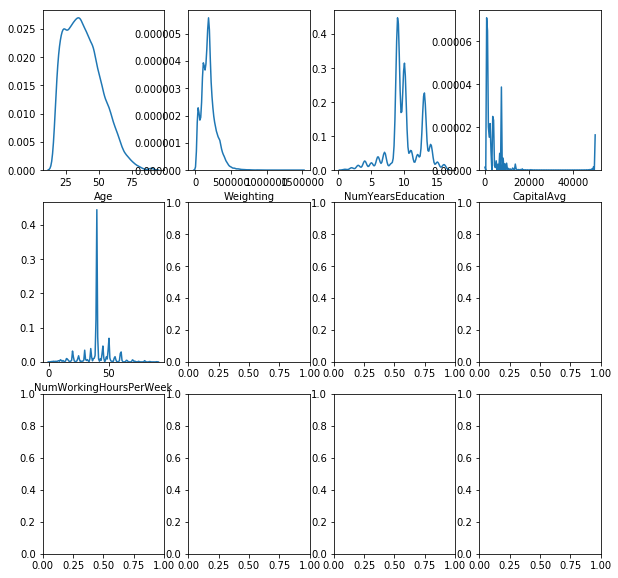

In [5]:
# get columns from X
cols = X.columns
cols = [col for col in cols]
cols.remove('Sex')
cols.remove('CountryOfOrigin')
cols.remove('Marital-Status')
cols.remove('Occupation')
cols.remove('Relationship')
cols.remove('WorkClass')
cols.remove('Education')
print(cols)

# visualise the columns
fig, ax = plt.subplots(3,4, figsize=(10,10), sharex=False)

# draw distplots on each inspected column in X
for i, col in enumerate(cols):
    sns.distplot(X[col].dropna(), hist=False, ax=ax[int(i/4)][i%4])
    
plt.show()

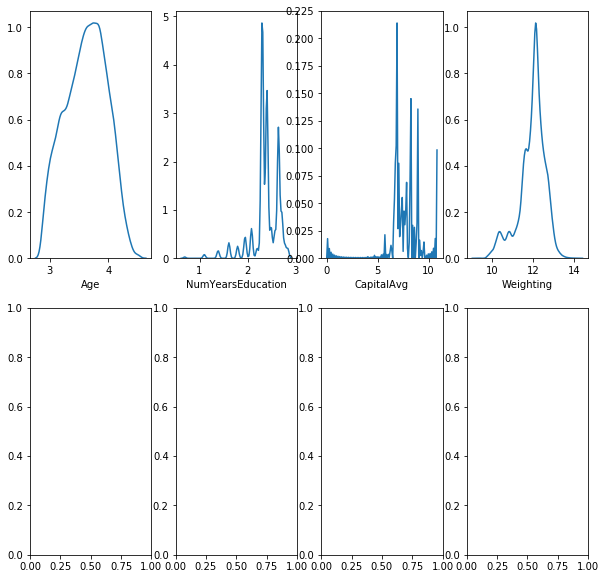

Model without GridSearchCV
Train accuracy: 0.8164580130317007
Test accuracy: 0.8169783926893842
Model with GridSearchCV
Train accuracy: 0.8164580130317007
Test accuracy: 0.8169783926893842
              precision    recall  f1-score   support

           0       0.68      0.43      0.53      2782
           1       0.84      0.94      0.89      8927

   micro avg       0.82      0.82      0.82     11709
   macro avg       0.76      0.69      0.71     11709
weighted avg       0.80      0.82      0.80     11709

{'C': 0.1}
NumYearsEducation : -0.9453408223967992
Age : -0.7568223544543007
CapitalAvg : -0.5421807082146466
Sex : 0.49761123091281423
NumWorkingHoursPerWeek : -0.41774538697278496
Marital-Status : 0.20267320375263237
Occupation : -0.14291837973106808
Weighting : -0.07856802627151731
WorkClass : -0.06566961595066934
Relationship : -0.06407082378824903
Education : 0.026810528697419532
CountryOfOrigin : -0.00458721058367145


In [6]:
# list columns to be transformed
rs = 10
columns_to_transform = ['Age', 'NumYearsEducation', 'CapitalAvg', 'Weighting']

# copy the dataframe
X_log = X.copy()

# transform the columns with np.log
for col in columns_to_transform:
    X_log[col] = X_log[col].apply(lambda x: x+1)
    X_log[col] = X_log[col].apply(np.log)

fig, ax = plt.subplots(2,4, figsize=(10,10), sharex=False)
for i, col in enumerate(columns_to_transform):
    sns.distplot(X_log[col].dropna(), hist=False, ax=ax[int(i/4)][i%4])
    
plt.show()

# start by splitting them again
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y, test_size=0.3, stratify=y, random_state=rs)

# scale
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log)
X_test_log = scaler_log.transform(X_test_log)

# Without gridsearch

logreg = LogisticRegression(random_state=rs)
logreg.fit(X_train_log, y_train_log)
print("Model without GridSearchCV")
print("Train accuracy:", logreg.score(X_train_log, y_train_log))
print("Test accuracy:", logreg.score(X_test_log, y_test_log))


# With gridsearch
params = {'C': [pow(10, x) for x in range(-10, 5)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Model with GridSearchCV")
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred_log = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred_log))

# print parameters of the best model
print(cv.best_params_)

# best features
coef = cv.best_estimator_.coef_[0]
feature_names = X_log.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

# Attempt to plot Logistic Regression Model as a graph

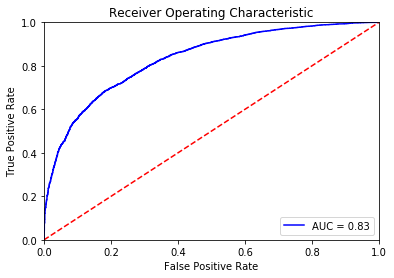

In [21]:
import seaborn as sns
from sklearn import metrics

probs = cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Task 4 Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier

# target/input split
y = df['AtRisk']
# Drop all object type
X = df.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=10)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


mlp = MLPClassifier(random_state=rs, alpha = 0.001, hidden_layer_sizes=8, early_stopping=True)
mlp.fit(X_train, y_train)

print("Train accuracy:", mlp.score(X_train, y_train))
print("Test accuracy:", mlp.score(X_test, y_test))

y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

print(mlp)

print(mlp.n_iter_)

Train accuracy: 0.8489274471044732
Test accuracy: 0.8473823554530703
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      2782
           1       0.87      0.94      0.90      8927

   micro avg       0.85      0.85      0.85     11709
   macro avg       0.80      0.75      0.77     11709
weighted avg       0.84      0.85      0.84     11709

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=8, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
32
